In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt5
# Add modules to the path
import sys
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git\\freely_moving_photometry_analysis' )

import joypy
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.signal import decimate
from utils.plotting import HeatMapParams
from utils.plotting import heat_map_and_mean, plot_one_side, calculate_error_bars
from utils.plotting import get_photometry_around_event
from scipy import stats
from utils.individual_trial_analysis_utils import ZScoredTraces, SessionData, CueAlignedData

In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [13]:
mouse = 'SNL_photo32'
date = '20210127'
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse + '\\'
restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
trial_data = pd.read_pickle(saving_folder + restructured_data_filename) 

In [8]:
plt.figure()
plt.plot(trial_data['Reward block'])


In [14]:
demod_signal = np.load(saving_folder + mouse + '_' + date + "_smoothed_signal.npy" )

In [15]:
plt.plot(demod_signal)

In [78]:
demod_signal.shape

(43985000,)

In [6]:
class CustomAlignedData(object):
    def __init__(self, session_data, params):
        saving_folder = 'W:\\photometry_2AC\\processed_data\\' + session_data.mouse + '\\'
        restructured_data_filename = session_data.mouse + '_' + session_data.date + '_' + 'restructured_data.pkl'
        trial_data = pd.read_pickle(saving_folder + restructured_data_filename)
        dff_trace_filename = session_data.mouse + '_' + session_data.date + '_' + 'smoothed_signal.npy'
        dff = np.load(saving_folder + dff_trace_filename)

        fiber_options = np.array(['left', 'right'])
        fiber_side_numeric = (np.where(fiber_options == session_data.fiber_side)[0] + 1)[0]
        contra_fiber_side_numeric = (np.where(fiber_options != session_data.fiber_side)[0] + 1)[0]

        self.ipsi_data = ZScoredTraces(trial_data, dff, params, fiber_side_numeric, 0)
        #self.ipsi_data.get_peaks()
        self.contra_data = ZScoredTraces(trial_data, dff,params, contra_fiber_side_numeric, 0)
        #self.contra_data.get_peaks()

In [7]:
def get_all_experimental_records():
    experiment_record = pd.read_csv('W:\\photometry_2AC\\experimental_record.csv')
    experiment_record['date'] = experiment_record['date'].astype(str)
    return experiment_record

In [8]:
def open_experiment(experiment_to_add):
    for index, experiment in experiment_to_add.iterrows():
        saving_folder = 'W:\\photometry_2AC\\processed_data\\' + experiment['mouse_id'] + '\\'
        restructured_data_filename = experiment['mouse_id'] + '_' + experiment['date'] + '_' + 'restructured_data.pkl'
        trial_data = pd.read_pickle(saving_folder + restructured_data_filename)
        dff_trace_filename = experiment['mouse_id'] + '_' + experiment['date'] + '_' + 'smoothed_signal.npy'
        dff = np.load(saving_folder + dff_trace_filename)
        session_traces = SessionData(experiment['fiber_side'], experiment['recording_site'], experiment['mouse_id'], experiment['date'])
    return session_traces

In [9]:
mouse_id = 'SNL_photo32'
date = '20210128'
all_experiments = get_all_experimental_records()
experiment_to_process = all_experiments[(all_experiments['date'] == date) & (all_experiments['mouse_id'] == mouse_id)]
session_data = open_experiment(experiment_to_process)

In [10]:
    params = {'state_type_of_interest': 3,
        'outcome':1,
        'last_outcome': 0,  # NOT USED CURRENTLY
        'no_repeats' : 1,
        'last_response': 0,
        'align_to' : 'Time end',
        'instance': -1,
        'plot_range': [-6, 6],
        'first_choice_correct': 0 ,
         'cue': None}
test = CustomAlignedData(session_data, params)

(340, 17)
(140, 160000)
(296, 17)
(151, 160000)


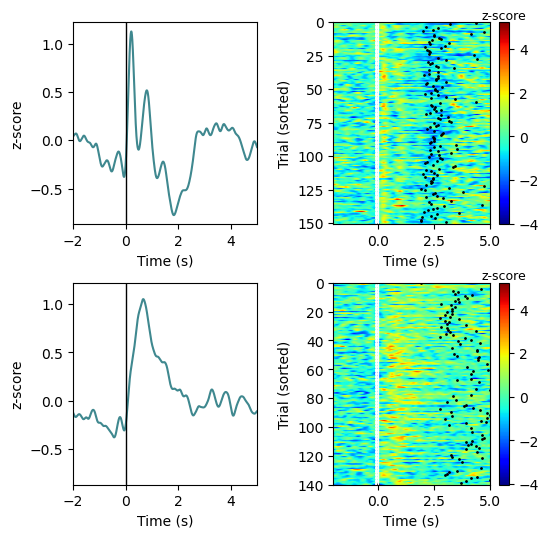

In [11]:
heat_map_and_mean(test, sort=False, error_bar_method=None,white_dot='default', mean_across_mice=False, xlims=[-2,5])

In [11]:
print('a')

a
